#### Setting up Colab and reading the necessary files

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1rhXGPo60Q2sxyR98lVJvGlfKGnWzq3wV' # Paste the shareable link here

fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.csv') # file will be stored as train.csv in the colab directory

1rhXGPo60Q2sxyR98lVJvGlfKGnWzq3wV


In [0]:
link = 'https://drive.google.com/open?id=1LyTPnT2zAq8kOL0uli4ipzUh5YOjUrKG' # Paste the shareable link here

fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('test.csv')

1LyTPnT2zAq8kOL0uli4ipzUh5YOjUrKG


In [0]:
import pandas as pd
#Reading the train and test data
df_train = pd.read_csv(r'train.csv', na_values = 'na')
df_test = pd.read_csv(r'test.csv', na_values = 'na')

print(df_train.shape, df_test.shape)
df_train.head()

#### Null value imputation on train data

In [0]:
#Checking for nulls
df_train.isnull().sum().sort_values(ascending = False)

sensor43_measure           49264
sensor42_measure           48722
sensor41_measure           47740
sensor40_measure           46333
sensor68_measure           46329
sensor2_measure            46329
sensor39_measure           44009
sensor38_measure           39549
sensor37_measure           27277
sensor36_measure           23034
sensor56_measure           14861
sensor65_measure           14861
sensor58_measure           14861
sensor57_measure           14861
sensor4_measure            14861
sensor71_measure           13808
sensor76_measure           13808
sensor75_measure           13808
sensor74_measure           13808
sensor73_measure           13808
sensor72_measure           13808
sensor78_measure           13808
sensor70_measure           13808
sensor77_measure           13808
sensor103_measure          10239
sensor63_measure            9877
sensor104_measure           9553
sensor62_measure            9553
sensor11_measure            4400
sensor51_measure            4356
          

In [0]:
#Splitting the dependant and independant variables
y = df_train['target']
df_train = df_train.drop(['target'], axis = 1)

X_train = df_train.drop(['id'], axis = 1)
X_test = df_test.drop(['id'], axis = 1)

print(X_train.shape, X_test.shape)

In [0]:
print(((X_train == 0).sum().sort_values(ascending = False)>30000).sum())
mask1 = (X_train == 0).sum()>30000

#Replace NaNs with zero in columns where there are more than 20000 zeros
X_train[X_train.columns[mask1 == True]] = X_train[X_train.columns[mask1 == True]].fillna(0)

53

In [0]:
print((X_train.isna().sum().sort_values(ascending = False)<10000).sum())
mask2 = X_train.isna().sum()<6000

#Imputing the columns with median value
X_train[X_train.columns[mask2 == True]] = X_train[X_train.columns[mask2 == True]].fillna(X_train.median())

148

In [0]:
print((X_train.isnull().sum().sort_values(ascending = False)>0).sum())
mask3 = X_train.isnull().sum() > 0

#Setting up the iterative imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter = 15, random_state = 0)
imp.fit(X_train[X_train.columns[mask3 == True]])

#Performing iterative imputation on the remaining columns with nulls
imp_result1 = pd.DataFrame(imp.transform(X_train[X_train.columns[mask3 == True]]))
imp_result1.columns = X_train.columns[mask3 == True]
X_train[X_train.columns[mask3 == True]] = imp_result1

24

#### Null value imputation on test data

In [0]:
# print(mask1 = (X_test == 0).sum()>8000)
#Replace NaNs with zero in columns where there are more than 20000 zeros
X_test[X_test.columns[mask1 == True]] = X_test[X_test.columns[mask1 == True]].fillna(0)

# print(mask2 = X_test.isna().sum()<1600)
#Imputing the columns with median value
X_test[X_test.columns[mask2 == True]] = X_test[X_test.columns[mask2 == True]].fillna(X_test.median())

mask3 = X_test.isnull().sum() > 0
imp = IterativeImputer(max_iter = 15, random_state = 0)
imp.fit(X_test[X_test.columns[mask3 == True]])

imp_result2 = pd.DataFrame(imp.transform(X_test[X_test.columns[mask3 == True]]))
imp_result2.columns = X_test.columns[mask3 == True]
X_test[X_test.columns[mask3 == True]] = imp_result1

#### Modeling - Random Forest

In [0]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 60, stop = 130, num = 8)]
# Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 4, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
# bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [60, 70, 80, 90, 100, 110, 120, 130], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 3, 4, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [0]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 4, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 28.5min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 31.1min finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [0]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 130}

In [0]:
#Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 125, random_state = 50, verbose = 1, n_jobs = -1, min_samples_split = 3)
rf_model = clf.fit(X_train, y)

ID_test = df_test['id']
pred_rf = pd.DataFrame(rf_model.predict(X_test), columns = ['target'])
pred_rf['id'] = ID_test

In [0]:
#Checking the feature importance
feature_importances = pd.DataFrame(rf_model.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances[:20]

,importance
sensor35_measure,0.035701
sensor17_measure,0.031562
sensor61_measure,0.031414
sensor46_measure,0.030132
sensor7_histogram_bin2,0.029990
sensor7_histogram_bin1,0.025210
sensor59_measure,0.025059
sensor13_measure,0.024055
sensor7_histogram_bin3,0.020726
sensor89_measure,0.020564


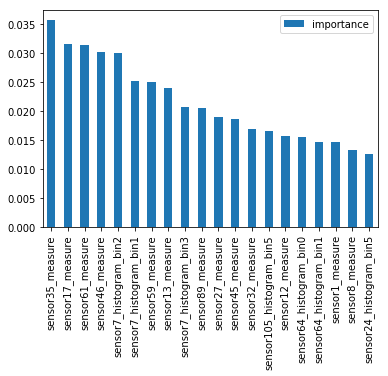

In [0]:
feature_importances[:20].plot(kind='bar')

In [0]:
## f1score
from sklearn.metrics import f1_score
f1_score(y, train_pred, average=None)

pred_rf.to_csv(r'attempt_5.csv')
# from google.colab import files
files.download('attempt_5.csv')

array([0.99999153, 0.99949975])

#### Modeling - Auto ML

In [0]:
# setting up the package

# !pip install requests
# !pip install tabulate
# !pip install "colorama>=0.3.8"
# !pip install future
# !pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o
  
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,06 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,2 days
H2O cluster name:,H2O_from_python_unknownUser_8kemnj
H2O cluster total nodes:,1
H2O cluster free memory:,2.938 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"locked, healthy"


In [0]:
train_h2o = df_train.copy()
train_h2o = h2o.H2OFrame(train_h2o)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
train_h2o['target'] = train_h2o['target'].asfactor()
h2o_automl = H2OAutoML(max_models = 2, max_runtime_secs=1800, seed = 1)
h2o_automl.train(y = 'target', training_frame = train_h2o)

AutoML progress: |████████████████████████████████████████

H2OConnectionError: ignored

In [0]:
h2o_leaderboard = h2o_automl.leaderboard
h2o_leaderboard.head()
h2o_leaderboard.head(rows=h2o_leaderboard.nrows) # Entire leaderboard

test_h2o = h2o.H2OFrame(df_test)
h20_prediction = h2o_automl.predict(test_h2o)
h20_prediction.as_data_frame(use_pandas=True).to_csv('h20_pred.csv')

#### Modeling - Light GBM

In [0]:
import lightgbm as lgb

lgbm_model = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : 8,
    "sub_sample":0.8,
    "num_leaves" : 31,
    "learning_rate" : 0.05,
    "seed": 42}

In [0]:
from sklearn.model_selection import train_test_split
lgbm_train,lgbm_val,lgbm_y_train,lgbm_y_val = train_test_split(X_train,y, test_size = 0.2, random_state = 42)

# taking data as LightGBM format
trn_data = lgb.Dataset(lgbm_train, label=lgbm_y_train)
val_data = lgb.Dataset(lgbm_val, label=lgbm_y_val)

fit_lgbm = lgb.LGBMClassifier(lgbm_train, lgbm_val, verbose_eval=500)

In [0]:
## f1score

from sklearn.metrics import f1_score
f1_score(lgbm_y_val, pred_lgbm, average=None)

array([0.99571143, 0.77505568])

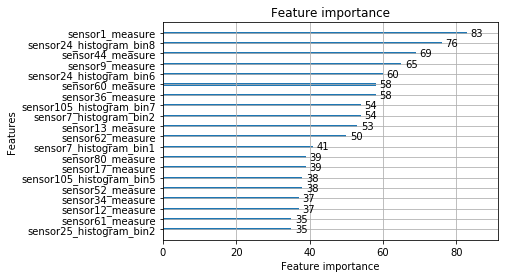

In [0]:
pred_lgbm = fit_lgbm.predict(lgbm_val)

for each in range(len(pred_lgbm)):
  if pred_lgbm[each] < 0.2:
    pred_lgbm[each] = 0
  else:
    pred_lgbm[each] = 1

lgb.plot_importance(fit_lgbm,max_num_features=20)

In [0]:
final_lgbm_pred = pd.DataFrame(pred_lgbm)
final_lgbm_pred.to_csv('xgb.csv')
files.download('xgb.csv')

#### Modeling - XG Boost

In [0]:
params = {
   
    'max_depth': 7, # to control over-fitting, optimal value range: 3-10
    'gamma' :0, # the minimum loss reduction required to make a split, XGB will build the tree first then prune in case of 0 gamma
    'eta':.03, # shrinkage factor, optimal value range: 0.01-0.2
    'subsample': 0.8, # fraction of observations to be randomly samples for each tree, optimal value range: 0.5-1
    'colsample_bytree': 0.8, # fraction of columns to be randomly samples for each tree, optimal value range: 0.5-1
    'scale_pos_weight' : 11.0, # for imbalanced data
    'objective':'binary:logistic', # loss function to be minimized
    'eval_metric':'auc', # metric to be used for validation data
    'silent': 0 # running messages will be printed
}

In [0]:
import xgboost as xgb
df_train = df_train.drop(['target'], axis = 1)

def XGBmodel(X_train,X_test,y_train,y_test,params):
    matrix_train = xgb.DMatrix(X_train,label=y_train)
    matrix_test = xgb.DMatrix(X_test,label=y_test)
    model=xgb.train(params=params,
                    dtrain=matrix_train,
                    num_boost_round=500, # number of boosting rounds or trees to build
                    early_stopping_rounds=10, # stop if performance haven’t improved for N rounds
                    evals=[(matrix_test,'test')]
                   )
    return model

xgb_train, xgb_val, xgb_y_train, xgb_y_val = train_test_split(df_train, y, test_size = 0.2, random_state = 42)
xgb_model = XGBmodel(xgb_train,xgb_val,xgb_y_train,xgb_y_val,params)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	test-auc:0.962915
Will train until test-auc hasn't improved in 10 rounds.
[1]	test-auc:0.968831
[2]	test-auc:0.969325
[3]	test-auc:0.969717
[4]	test-auc:0.967954
[5]	test-auc:0.974464
[6]	test-auc:0.974776
[7]	test-auc:0.977019
[8]	test-auc:0.98145
[9]	test-auc:0.981605
[10]	test-auc:0.983783
[11]	test-auc:0.983241
[12]	test-auc:0.983164
[13]	test-auc:0.983205
[14]	test-auc:0.983394
[15]	test-auc:0.983362
[16]	test-auc:0.983368
[17]	test-auc:0.983394
[18]	test-auc:0.983475
[19]	test-auc:0.983434
[20]	test-auc:0.983391
Stopping. Best iteration:
[10]	test-auc:0.983783



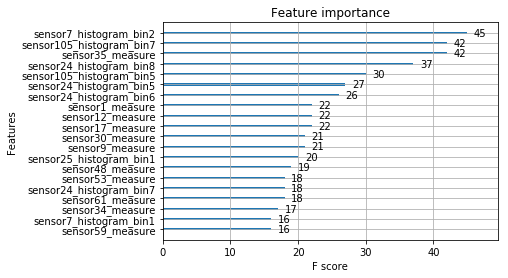

In [0]:
xgb.plot_importance(xgb_model, max_num_features=20)

In [0]:
xgb_test = xgb.DMatrix(df_test)

pred_xgb = xgb_model.predict(xgb_test, ntree_limit = xgb_model.best_ntree_limit).tolist()
final_xgb_pred = pd.DataFrame(pred_xgb)
final_xgb_pred.to_csv('XGB.csv')
files.download('XGB.csv')